In [1]:
from sampling.mutate import mutate
from sampling.crossover import crossover
from sampling.random_sample import generate_random_samples

In [2]:
import open_clip
import numpy as np
import torch

/Users/ericmusa/Documents/Coding/Python/reverse-clip-captions/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model, _, preprocess = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k_augreg')
# model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='commonpool_m_clip_s128m_b4k')

In [4]:
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 179,385,345
Context length: 77
Vocab size: 49408


In [6]:
def process_images(images, features=True):
    result = torch.tensor(np.stack([preprocess(_) for _ in images]))
    if features:
        with torch.no_grad():
            result = model.encode_image(result).float()
            result /= result.norm(dim=-1, keepdim=True)
    return result

In [7]:
from open_clip import tokenizer

def process_texts(texts, features=True):
    result = tokenizer.tokenize(texts)
    if features:
        with torch.no_grad():
            result = model.encode_text(result).float()
            result /= result.norm(dim=-1, keepdim=True)
    return result

In [8]:
def feature_similarities(features_a, features_b):
    return features_a.cpu().numpy() @ features_b.cpu().numpy().T


def texts_images_similarities(texts, images):
    if all(isinstance(_, str) for _ in images):
        images = [Image.open(_).convert('RGB') for _ in images]
    text_features = process_texts(texts)
    image_features = process_images(images)
    return feature_similarities(text_features, image_features)

In [9]:
import matplotlib.pyplot as plt

def similarities_heat_map(texts, images):
    similarities = texts_images_similarities(texts, images)
    plt.figure(figsize=(20, 14))
    plt.imshow(similarities, vmin=0.1, vmax=0.5)
    plt.colorbar()
    plt.yticks(range(len(texts)), texts, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(images):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
    for x in range(similarities.shape[1]):
        for y in range(similarities.shape[0]):
            plt.text(x, y, f"{similarities[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, len(images) - 0.5])
    plt.ylim([len(texts) + 0.5, -2])

    plt.title("Cosine similarity between text and image features", size=20)

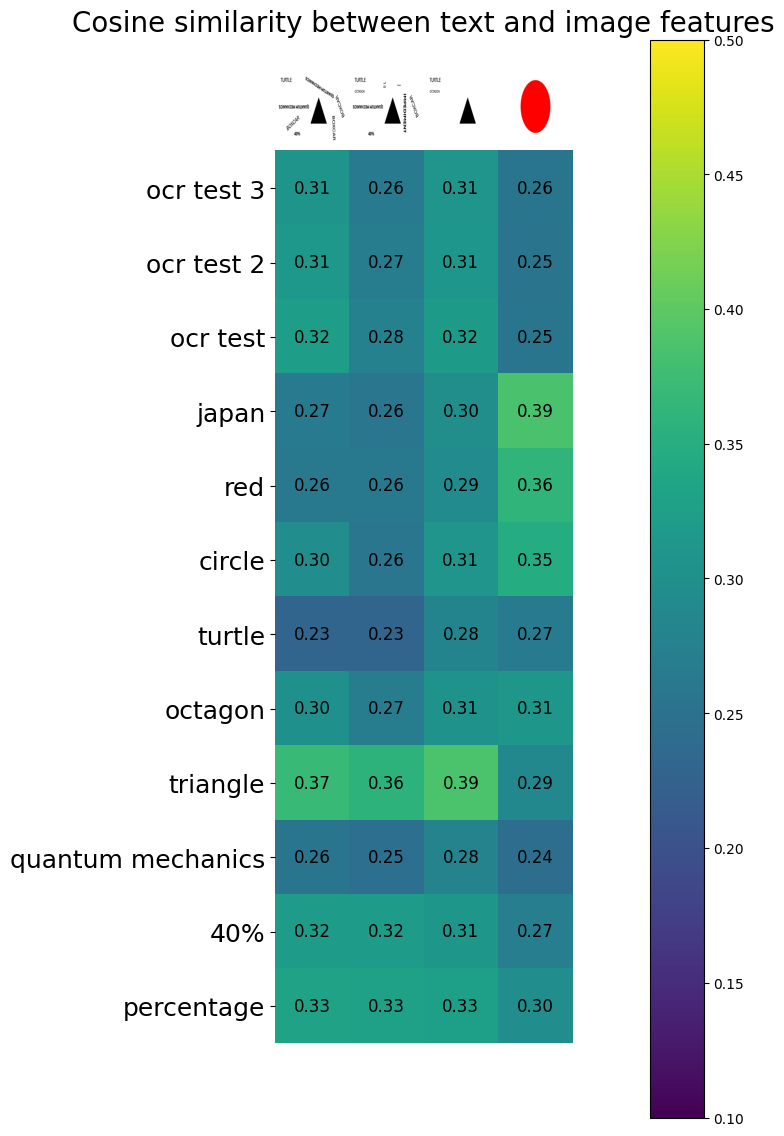

In [18]:
import os
from PIL import Image

image_paths = [os.path.join('images', _) for _ in os.listdir('images')]

images_dict = {_: Image.open(_).convert("RGB") for _ in image_paths}

images = []
texts = []

# for fname, image in images_dict.items():
#     images.append(image)
#     texts.append(os.path.split(fname)[1].split('.')[0])

for fname, image in images_dict.items():
    if 'ocr' in fname or 'japan' in fname:
        # continue
        images.append(image)
        texts.append(os.path.split(fname)[1].split('.')[0])


texts += \
    ['red', 'circle'] + \
    ['turtle', 'octagon', 'triangle'] + \
    ['quantum mechanics', '40%', 'percentage']
    # ['quantum mechanics', 'gown', '40%', 'percentage', '30%', '5 L', 'liters'] + \
similarities_heat_map(texts, images)